In [0]:
## Filter Visualization

In [0]:
import torch
import torch.nn as nn
from torch.autograd import Variable
from torchvision import models
from torchvision import transforms, utils

In [0]:
import numpy as np
import scipy.misc
import matplotlib.pyplot as plt
%matplotlib inline
from PIL import Image
import json

In [0]:
def to_grayscale(image):
    image = torch.sum(image, dim=0)
    image = torch.div(image, image.shape[0])
    return image

In [0]:
def normalize(image):
    normalize = transforms.Normalize(
    mean=[0.485, 0.456, 0.406],
    std=[0.229, 0.224, 0.225]
    )
    preprocess = transforms.Compose([
    transforms.Resize((224,224)),
    transforms.ToTensor(),
    normalize
    ])
    image = Variable(preprocess(image).unsqueeze(0).cuda())
    return image


def predict(image):
    _, index = vgg(image).data[0].max(0)
    return str(index.item())
    
def deprocess(image):
    return image * torch.Tensor([0.229, 0.224, 0.225]).cuda()  + torch.Tensor([0.485, 0.456, 0.406]).cuda()

def load_image(path):
    image = Image.open(path)
    plt.imshow(image)
    plt.title("Image loaded successfully")
    return image

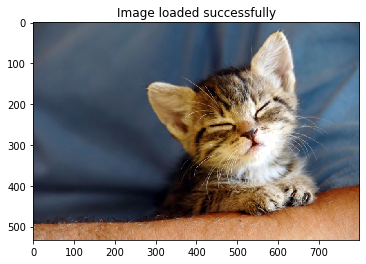

In [0]:
kitten_1 = load_image("kitten_1.jpg")

In [0]:
vgg = models.vgg16(pretrained=True)

Downloading: "https://download.pytorch.org/models/vgg16-397923af.pth" to /root/.cache/torch/checkpoints/vgg16-397923af.pth
100%|██████████| 528M/528M [00:06<00:00, 85.7MB/s]


In [0]:
vgg = vgg.cuda()

In [0]:
print(vgg)

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1

In [0]:
kitten_2 = normalize(kitten_1)
print(predict(kitten_2))

285


In [0]:
modulelist = list(vgg.features.modules())

In [0]:
def layer_outputs(image):
    outputs = []
    names = []
    for layer in modulelist[1:]:
        image = layer(image)
        outputs.append(image)
        names.append(str(layer))
        
    output_im = []
    for i in outputs:
        i = i.squeeze(0)
        temp = to_grayscale(i)
        output_im.append(temp.data.cpu().numpy())
        
    fig = plt.figure(figsize=(20,30))


    for i in range(len(output_im)):
        a = fig.add_subplot(8,4,i+1)
        imgplot = plt.imshow(output_im[i])
        plt.axis('off')
        a.set_title(names[i].partition('(')[0], fontsize=30)

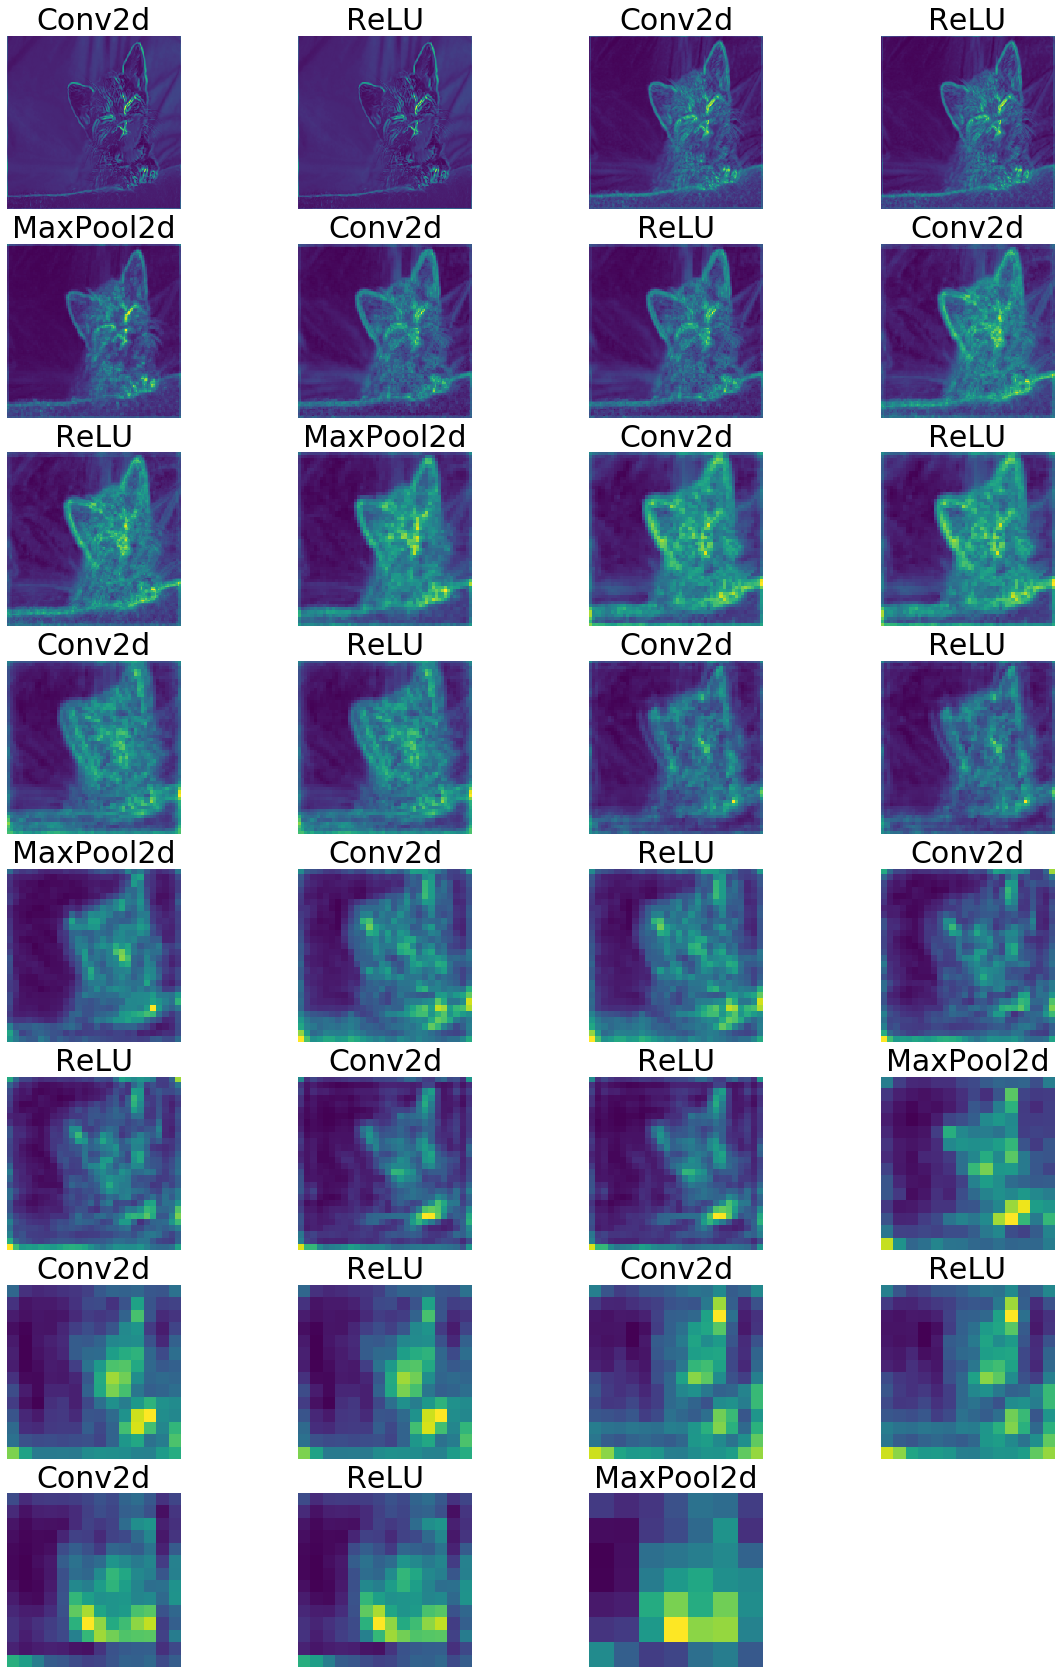

In [0]:
layer_outputs(kitten_2)

In [0]:
def filter_outputs(image, layer_to_visualize):
    if layer_to_visualize < 0:
        layer_to_visualize += 31
    output = None
    name = None
    for count, layer in enumerate(modulelist[1:]):
        image = layer(image)
        if count == layer_to_visualize: 
            output = image
            name = str(layer)
    
    filters = []
    output = output.data.squeeze()
    for i in range(output.shape[0]):
        filters.append(output[i,:,:])
        
    fig = plt.figure()
    plt.rcParams["figure.figsize"] = (20, 30)

    for i in range(int(np.sqrt(len(filters))) * int(np.sqrt(len(filters)))):
        fig.add_subplot(np.sqrt(len(filters)), np.sqrt(len(filters)),i+1)
        imgplot = plt.imshow(filters[i].cpu())
        plt.axis('off')
    

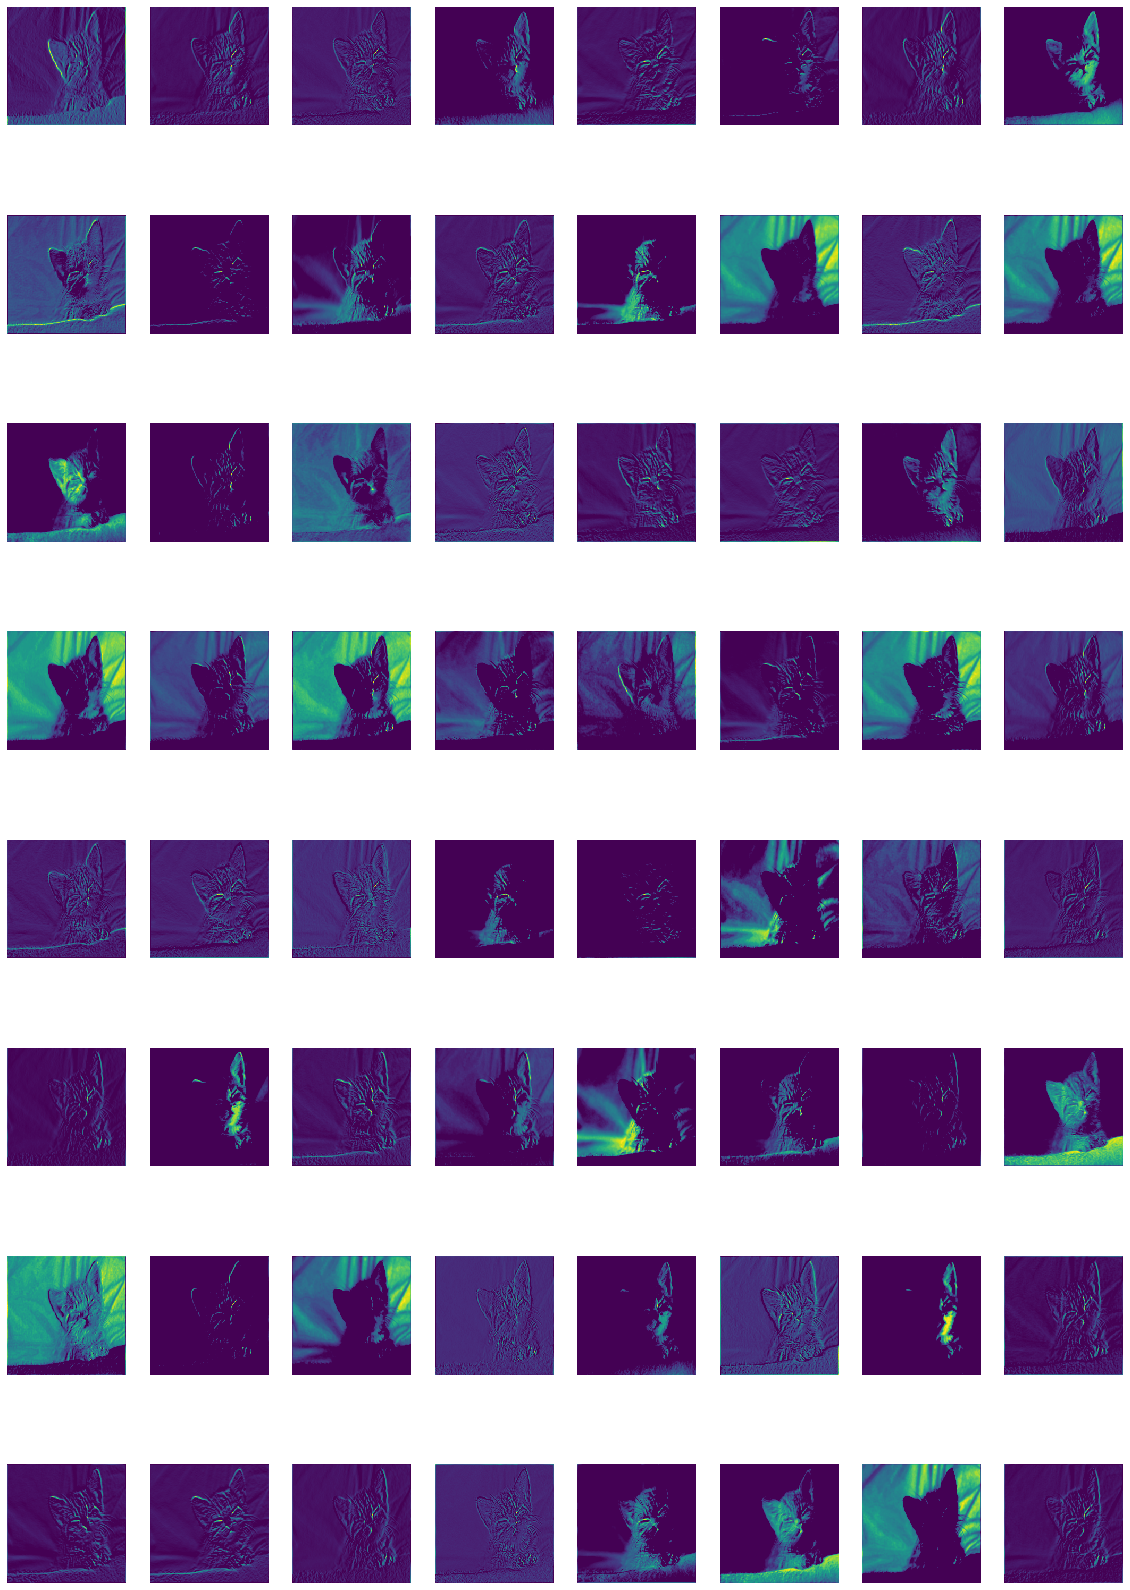

In [0]:
filter_outputs(kitten_2, 0)

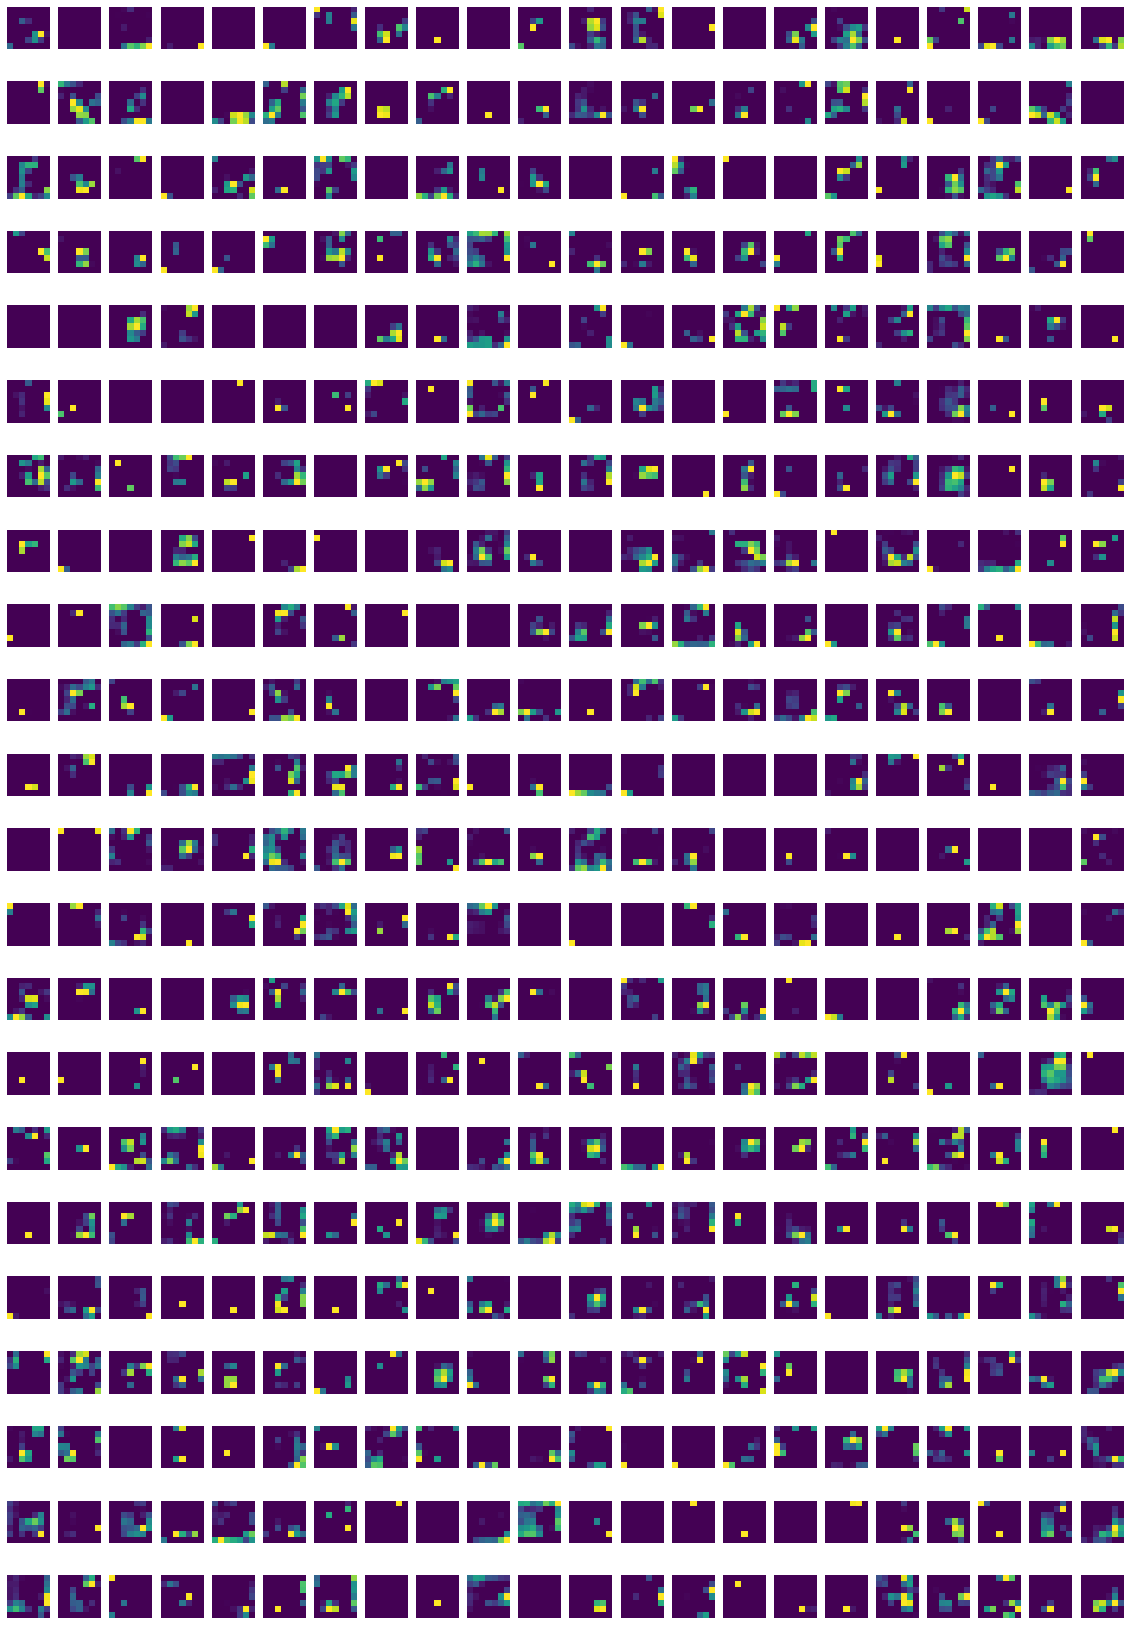

In [0]:
filter_outputs(kitten_2, -1)

In [0]:
def visualize_weights(image, layer):
    weight_used = []
    for w in vgg.features.children():
        if isinstance(w, torch.nn.modules.conv.Conv2d):
            weight_used.append(w.weight.data)

    filters = []
    for i in range(weight_used[layer].shape[0]):
        filters.append(weight_used[layer][i,:,:,:].sum(dim=0))
        filters[i].div(weight_used[layer].shape[1])
        
    fig = plt.figure()
    plt.rcParams["figure.figsize"] = (20, 30)
    for i in range(int(np.sqrt(weight_used[layer].shape[0])) * int(np.sqrt(weight_used[layer].shape[0]))):
        a = fig.add_subplot(np.sqrt(weight_used[layer].shape[0]),np.sqrt(weight_used[layer].shape[0]),i+1)
        imgplot = plt.imshow(filters[i].cpu())
        plt.axis('off')

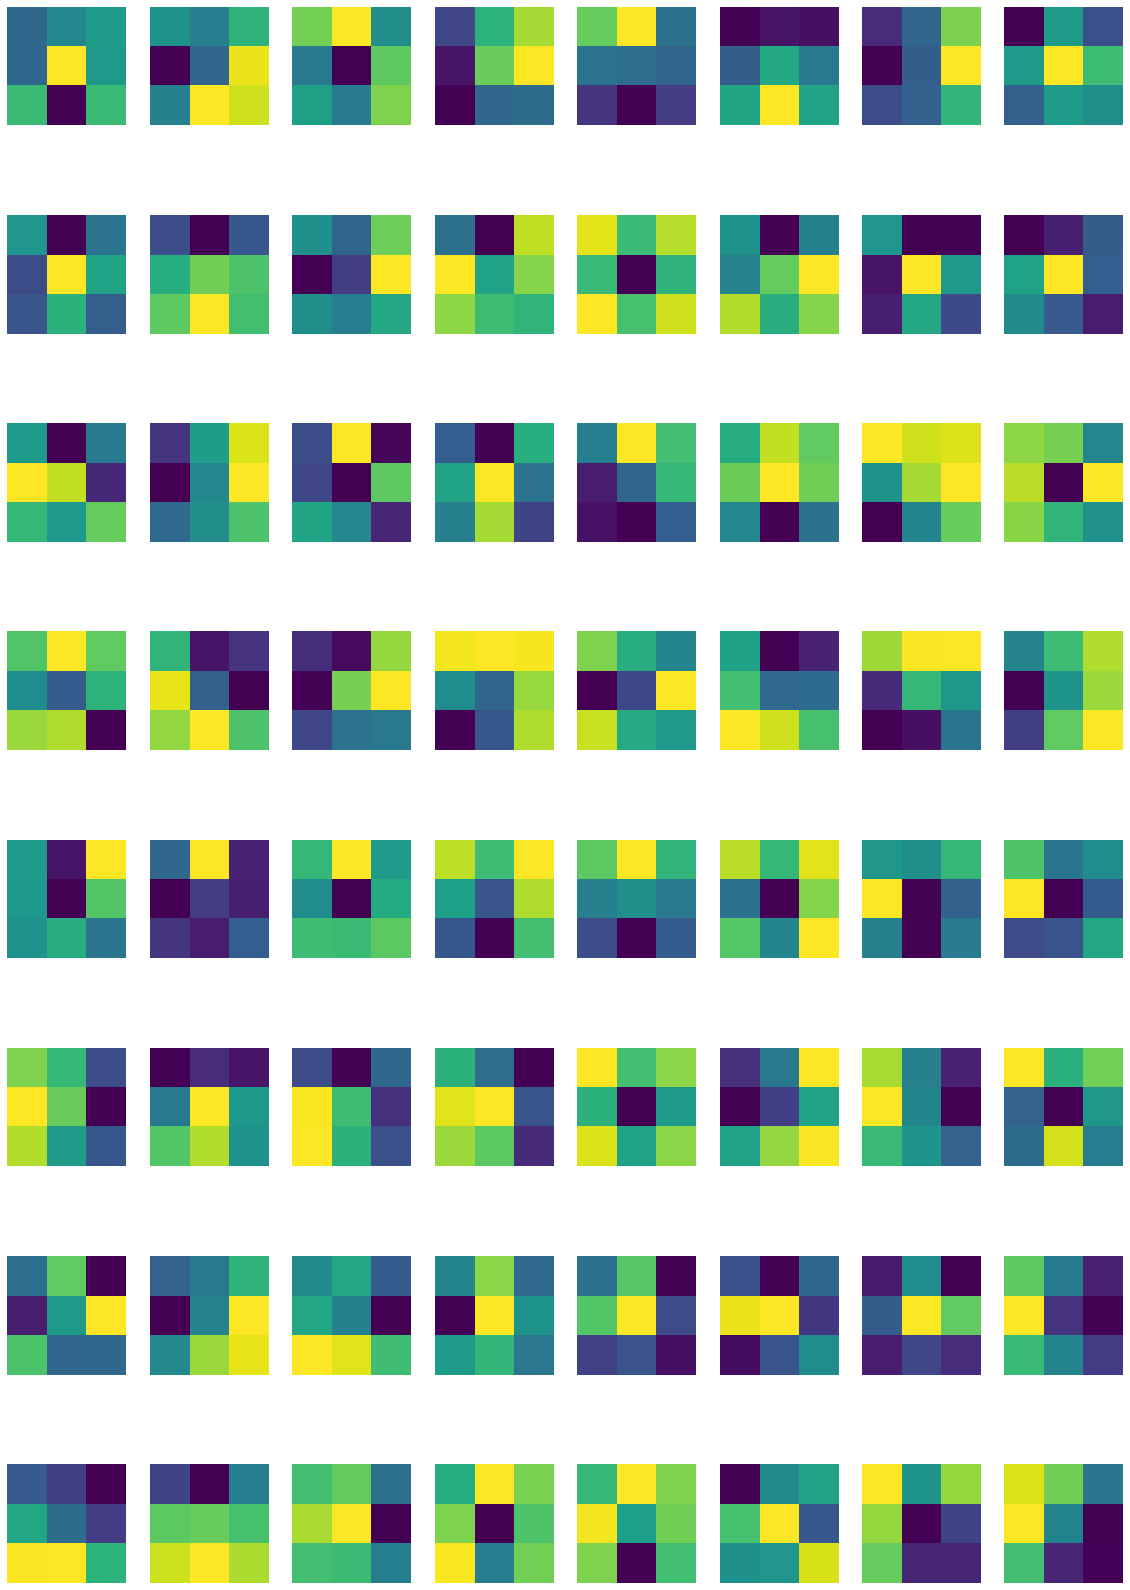

In [0]:

# First conv layer filters
visualize_weights(kitten_2, 0)

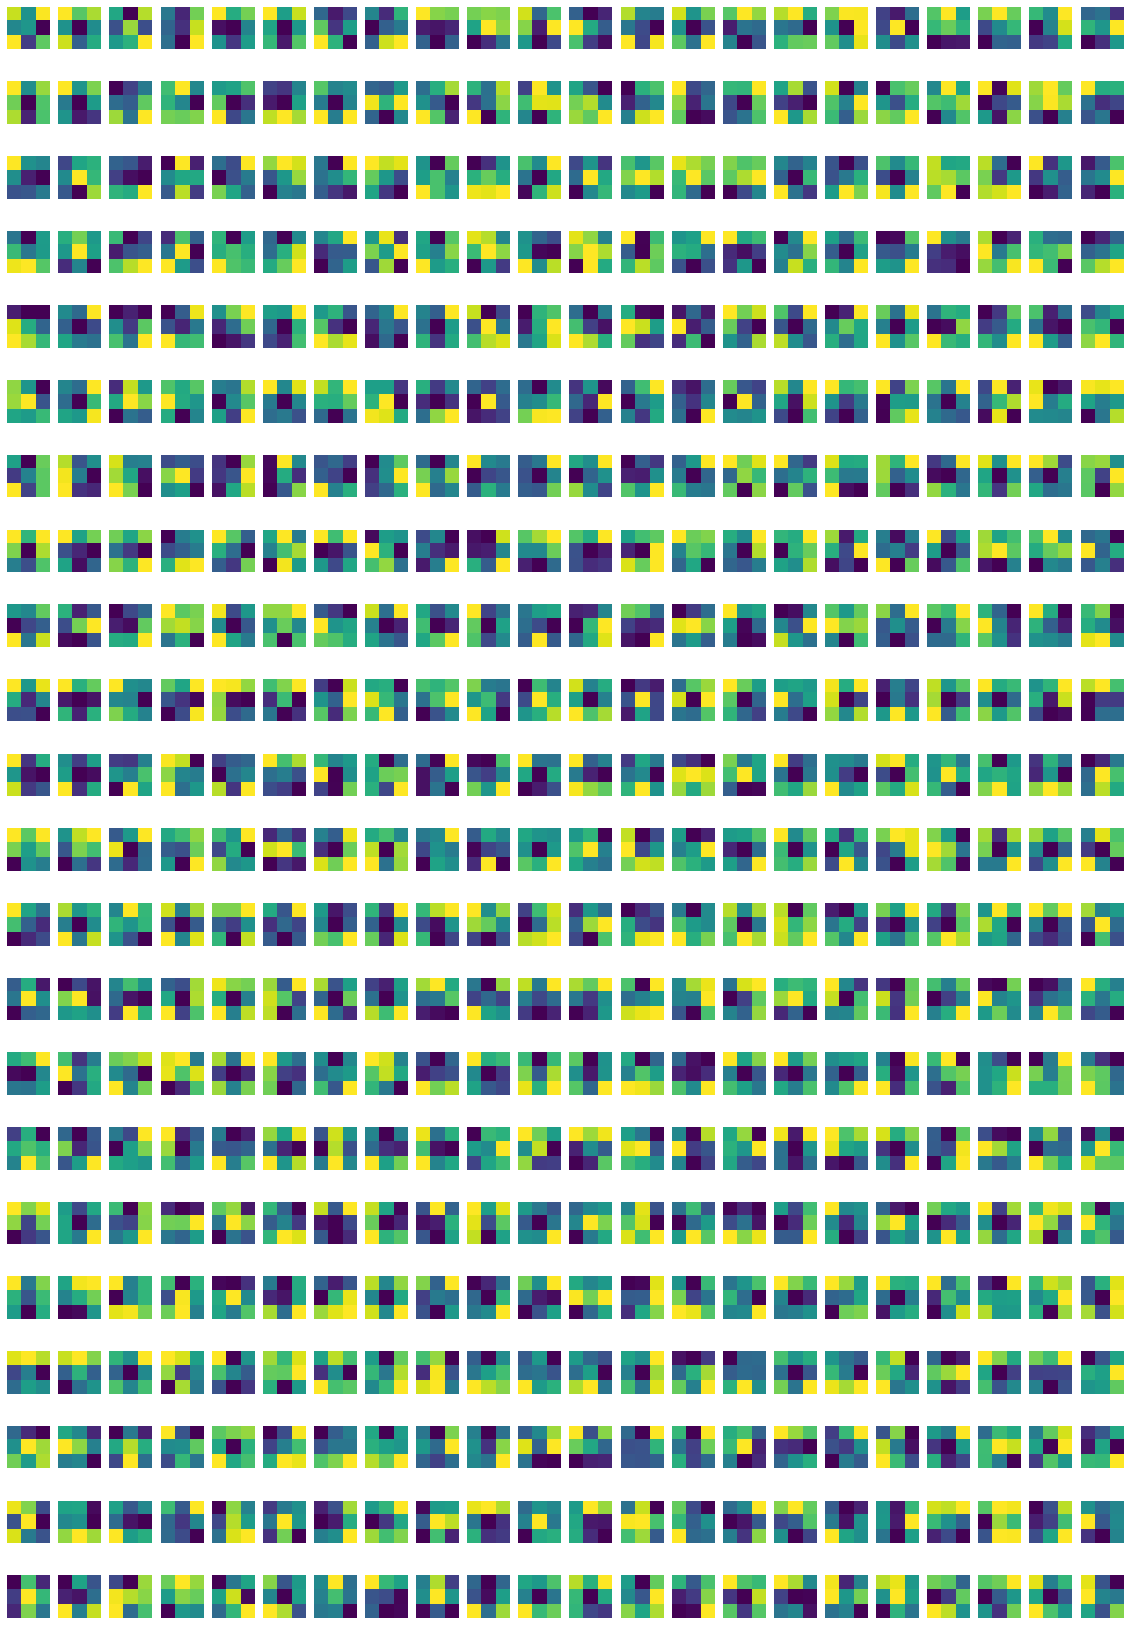

In [0]:

# Last conv layer filters
visualize_weights(kitten_2, -1)

In [0]:
def make_heatmap(image, true_class, k=8, stride=8): 
    heatmap = torch.zeros(int(((image.shape[2]-k)/stride)+1), int(((image.shape[3]-k)/stride)+1))
    image = image.data

    i = 0
    a = 0
    while i<=image.shape[3]-k:
        j = 0 
        b = 0
        while j<=image.shape[2]-k:
            h_filter = torch.ones(image.shape)
            h_filter[:,:,j:j+k, i:i+k] = 0
            temp_image = Variable((image.cuda() * h_filter.cuda()).cuda())
            temp_softmax = vgg(temp_image)
            temp_softmax = torch.nn.functional.softmax(temp_softmax).data[0]
            heatmap[a][b] = temp_softmax[true_class]
            j += stride
            b += 1
        print(a)
        i += stride
        a += 1
    
    image = image.squeeze()
    
    true_image = image.transpose(0,1)
    true_image = true_image.transpose(1,2)
    # Un-Normalize image
    true_image = true_image * torch.Tensor([0.229, 0.224, 0.225]).cuda()  + torch.Tensor([0.485, 0.456, 0.406]).cuda()
    
    # Plot both images
    fig = plt.figure()
    plt.rcParams["figure.figsize"] = (20, 20)
    
    a = fig.add_subplot(1,2,1)
    imgplot = plt.imshow(true_image.cpu())
    plt.title('Original Image')
    plt.axis('off') 
    
    # Normalize heatmap
    heatmap = heatmap - heatmap.min()
    heatmap = np.uint8(255 * heatmap)
    
    a = fig.add_subplot(1,2,2)
    imgplot = plt.imshow(heatmap)
    plt.title('Heatmap')
    plt.axis('off') 
    
    return heatmap

In [0]:
    i = 0
    a = 0
    while i<=image.shape[3]-k:
        j = 0 
        b = 0
        while j<=image.shape[2]-k:
            h_filter = torch.ones(image.shape)
            h_filter[:,:,j:j+k, i:i+k] = 0
            temp_image = Variable((image.cuda() * h_filter.cuda()).cuda())
            temp_softmax = vgg(temp_image)
            temp_softmax = torch.nn.functional.softmax(temp_softmax).data[0]
            heatmap[a][b] = temp_softmax[true_class]
            j += stride
            b += 1
        print(a)
        i += stride
        a += 1

In [0]:
h_filter = torch.ones(kitten_2.shape)
h_filter[:,:,4*32:4*32+64, 4*32:4*32+64] = 0
kitten_2_masked = (kitten_2.cuda() * h_filter.cuda()).cuda()



In [0]:
vgg(kitten_2_masked)

tensor([[-1.9516,  1.9991, -2.4538,  0.4413, -1.8010,  0.1329,  0.9826, -2.4418,
         -1.7698, -1.7371, -0.1632, -1.1517,  0.7522, -1.1956, -1.2597,  1.0724,
         -1.5735,  0.0354, -0.6498, -1.7220, -2.9740,  0.1368, -1.7283, -1.6522,
         -0.7245, -2.8711, -3.8704, -1.0554, -3.6275, -0.1827, -1.5854, -1.0817,
         -2.5131, -1.3839, -0.4360, -2.6908,  2.0993, -0.8448,  0.2880, -0.7546,
         -1.4181, -1.5300, -0.3013,  2.0922, -1.3615, -1.0185, -0.8050, -0.1010,
         -3.8014, -2.9069, -2.3386, -2.2785, -1.8114, -2.3929, -0.0756, -3.7147,
         -3.2662, -2.9937, -3.9857, -0.9475, -2.1188, -1.7327, -3.2926, -2.6623,
         -2.4281, -3.3571, -0.4973, -0.3561, -2.4064,  1.4670, -3.6155,  1.2398,
         -2.5342, -1.8941, -3.4242, -3.0830,  2.8407, -0.9817,  0.1018,  0.2217,
         -1.7897, -3.6861,  0.2385, -1.4157, -1.6269, -0.9048, -1.2795,  0.2938,
         -0.2865, -0.6158, -0.9131, -3.1804, -3.8853, -3.0196, -0.7702, -2.9924,
         -2.9601, -2.8427, -

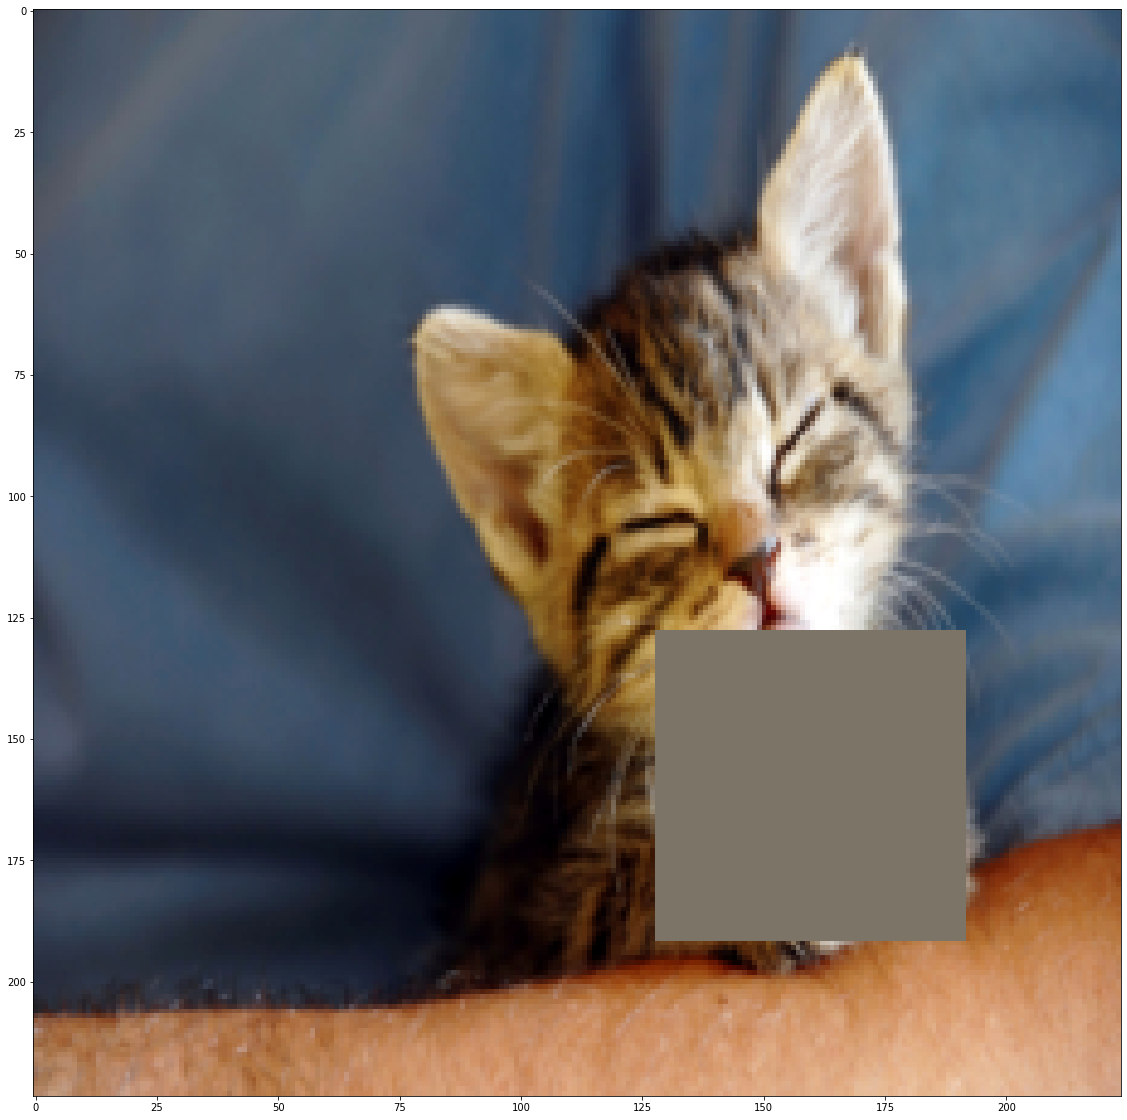

In [0]:
kitten_2_masked = kitten_2_masked.squeeze()
unnormed_kit_masked = kitten_2_masked.transpose(0,1)
unnormed_kit_masked = unnormed_kit_masked.transpose(1,2)
unnormed_kit_masked = unnormed_kit_masked * torch.Tensor([0.229, 0.224, 0.225]).cuda()  + torch.Tensor([0.485, 0.456, 0.406]).cuda()
plt.imshow(unnormed_kit_masked.cpu())

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:15: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  from ipykernel import kernelapp as app


0
1
2
3
4
5


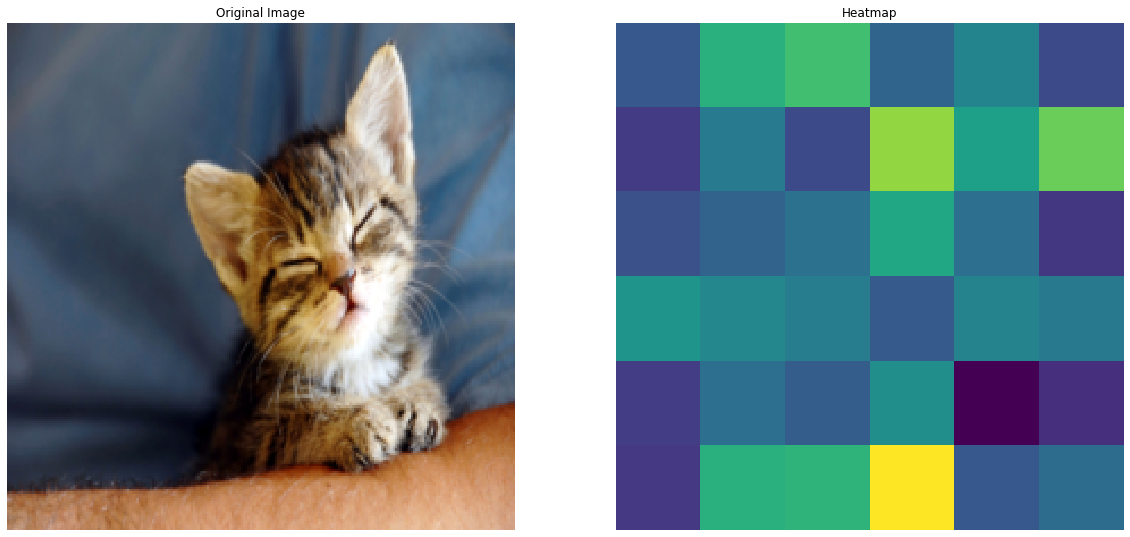

In [0]:
heatmap = make_heatmap(kitten_2, 285, 64, 32)

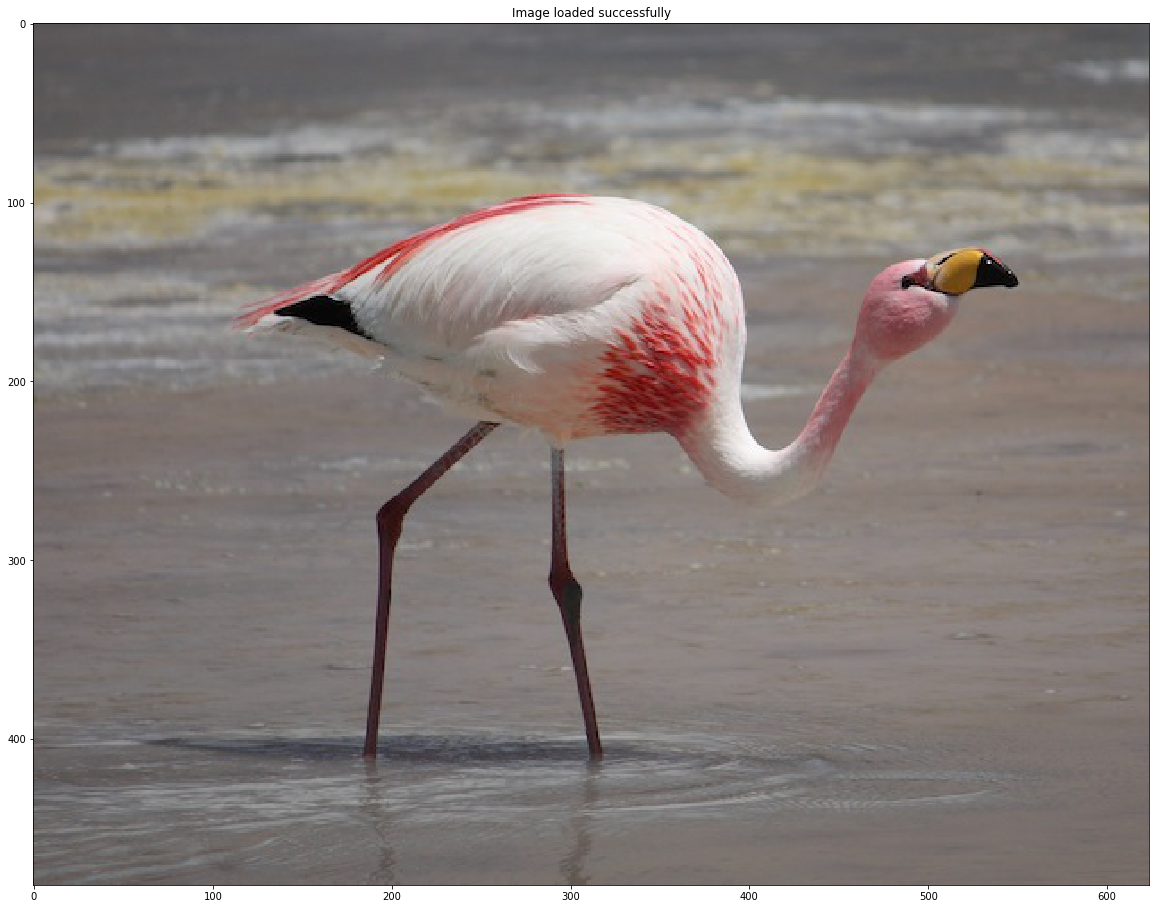

In [0]:
flamingo = normalize(load_image('flamingo.jpg'))

In [0]:
predict(flamingo)

'129'

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:15: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  from ipykernel import kernelapp as app


0
1
2
3
4
5


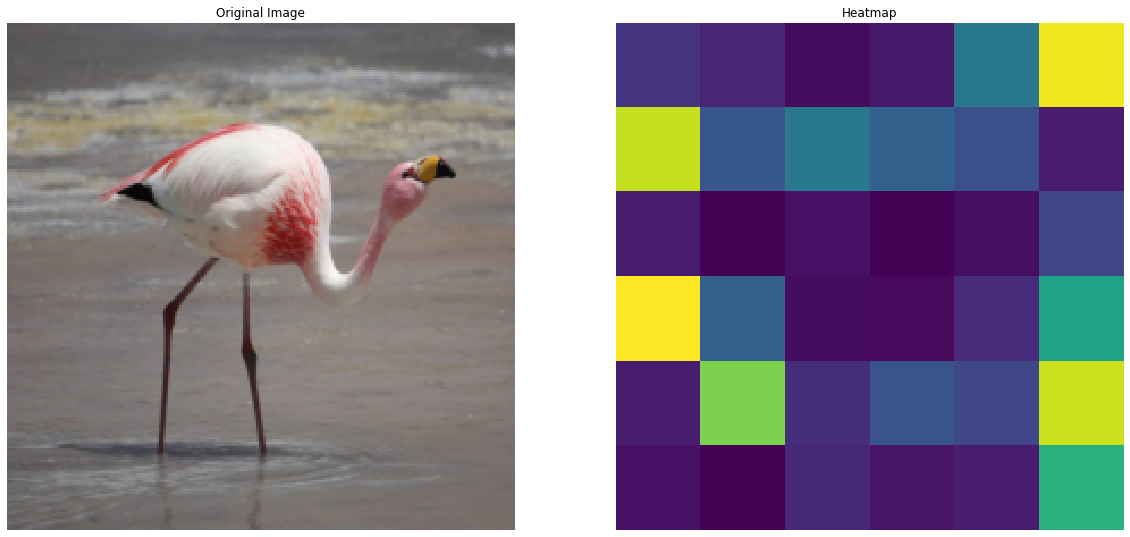

In [0]:
heatmap = make_heatmap(flamingo, 129, 64, 32)

In [0]:
normalise = transforms.Normalize(
    mean=[0.485, 0.456, 0.406],
    std=[0.229, 0.224, 0.225]
    )
preprocess = transforms.Compose([
    transforms.Resize((224,224)),
    transforms.ToTensor(),
    normalise
    ])

In [0]:
def make_saliency_map(input, label):
    input = Variable(preprocess(input).unsqueeze(0).cuda(), requires_grad=True)
    output = vgg.forward(input)
    output[0][label].backward()
    grads = input.grad.data.clamp(min=0)
    grads.squeeze_()
    grads.transpose_(0,1)
    grads.transpose_(1,2)
    grads = np.amax(grads.cpu().numpy(), axis=2)
    
    true_image = input.data
    true_image = true_image.squeeze()
    true_image = true_image.transpose(0,1)
    true_image = true_image.transpose(1,2)
    true_image = deprocess(true_image)

    fig = plt.figure()
    plt.rcParams["figure.figsize"] = (20, 20)


    a = fig.add_subplot(1,2,1)
    imgplot = plt.imshow(true_image.cpu())
    plt.title('Original Image')
    plt.axis('off')

    a = fig.add_subplot(1,2,2)
    imgplot = plt.imshow(grads)
    plt.axis('off') 
    plt.title('Saliency Map')


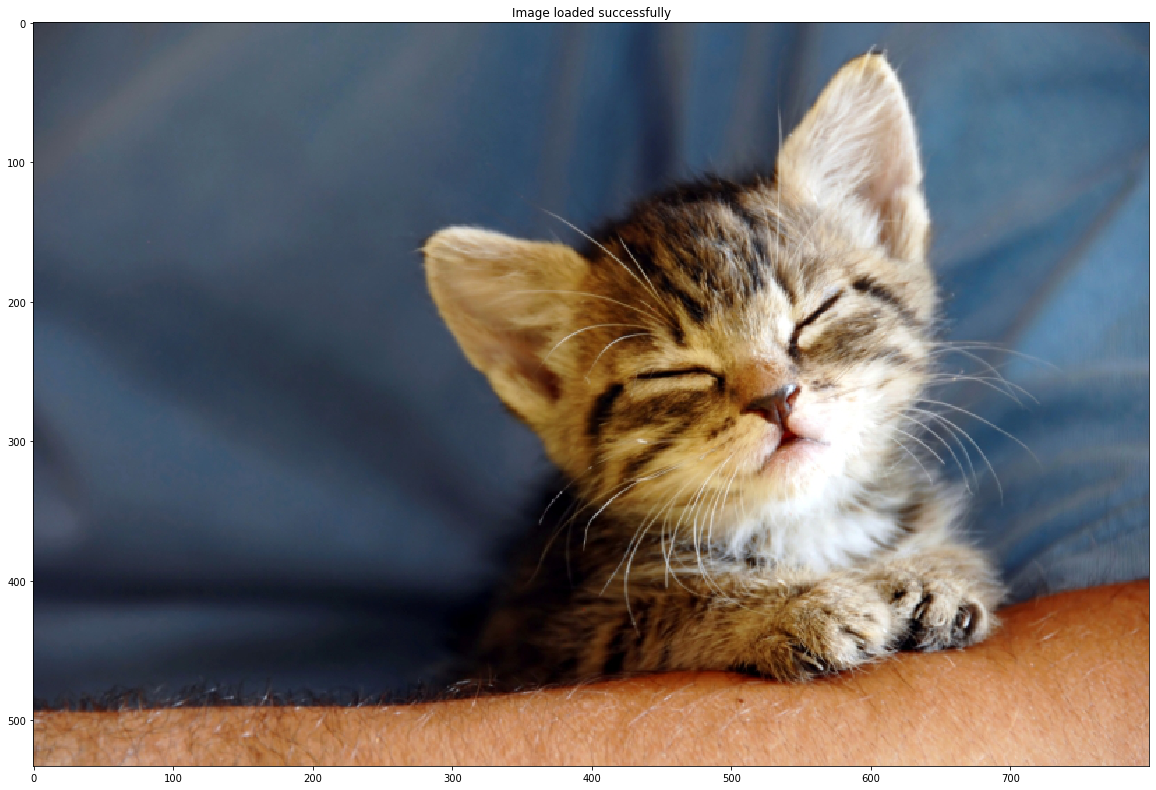

In [0]:
flamingo = load_image('flamingo.jpg')
kitten = load_image('kitten_1.jpg')

In [0]:
predict(normalize(flamingo))

'130'

In [0]:
predict(normalize(kitten))

'281'

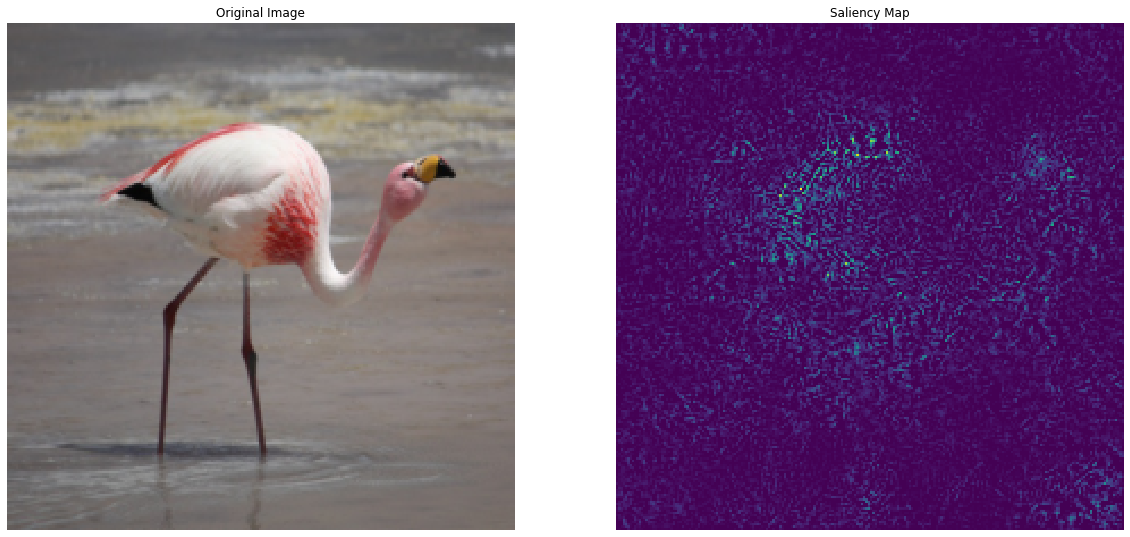

In [0]:
make_saliency_map(flamingo, 130)

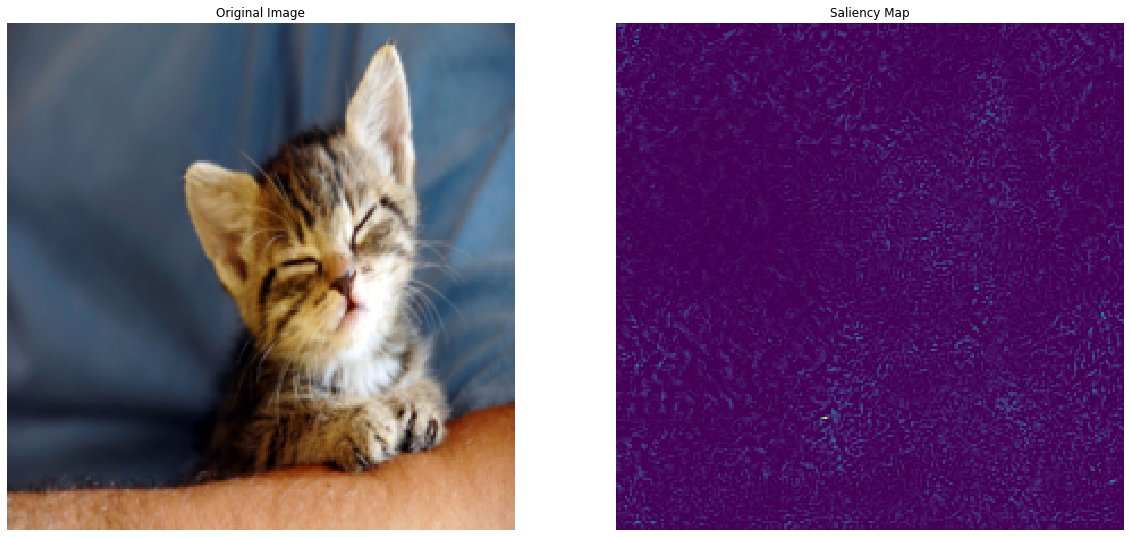

In [0]:
make_saliency_map(kitten, 281)

In [0]:
## Style Transfer

In [0]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

from PIL import Image
import matplotlib.pyplot as plt

import torchvision.transforms as transforms
import torchvision.models as models

import copy

In [0]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [0]:
# desired size of the output image
imsize = 512 if torch.cuda.is_available() else 128  # use small size if no gpu

loader = transforms.Compose([
    transforms.Resize(imsize),  # scale imported image
    transforms.ToTensor()])  # transform it into a torch tensor


def image_loader(image_name):
    image = Image.open(image_name)
    # fake batch dimension required to fit network's input dimensions
    image = loader(image).unsqueeze(0)
    return image.to(device, torch.float)


style_img = image_loader("picasso.jpg")
content_img = image_loader("dancing.jpg")

assert style_img.size() == content_img.size(), \
    "we need to import style and content images of the same size"

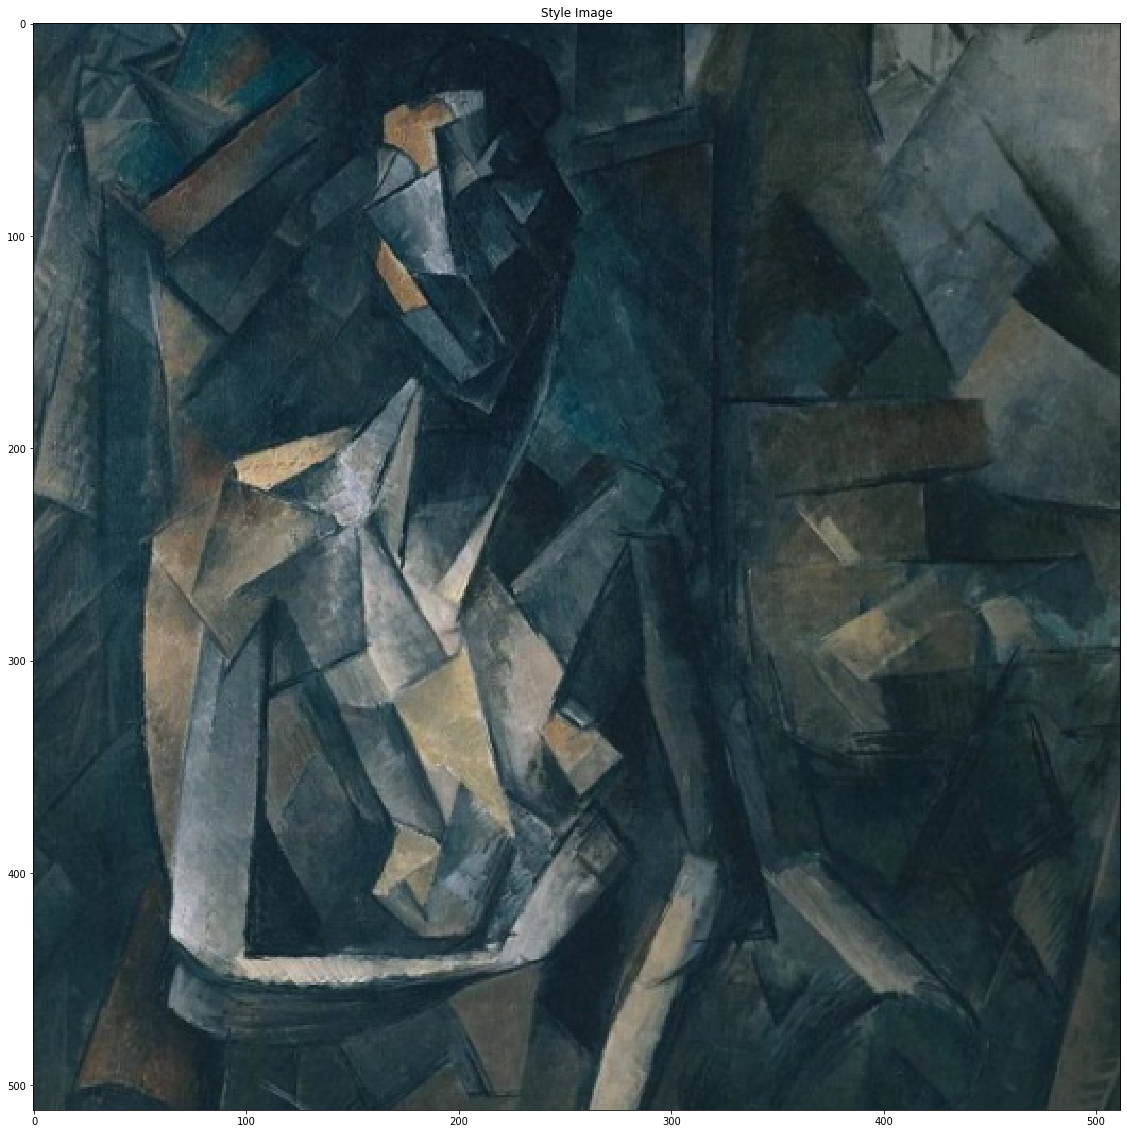

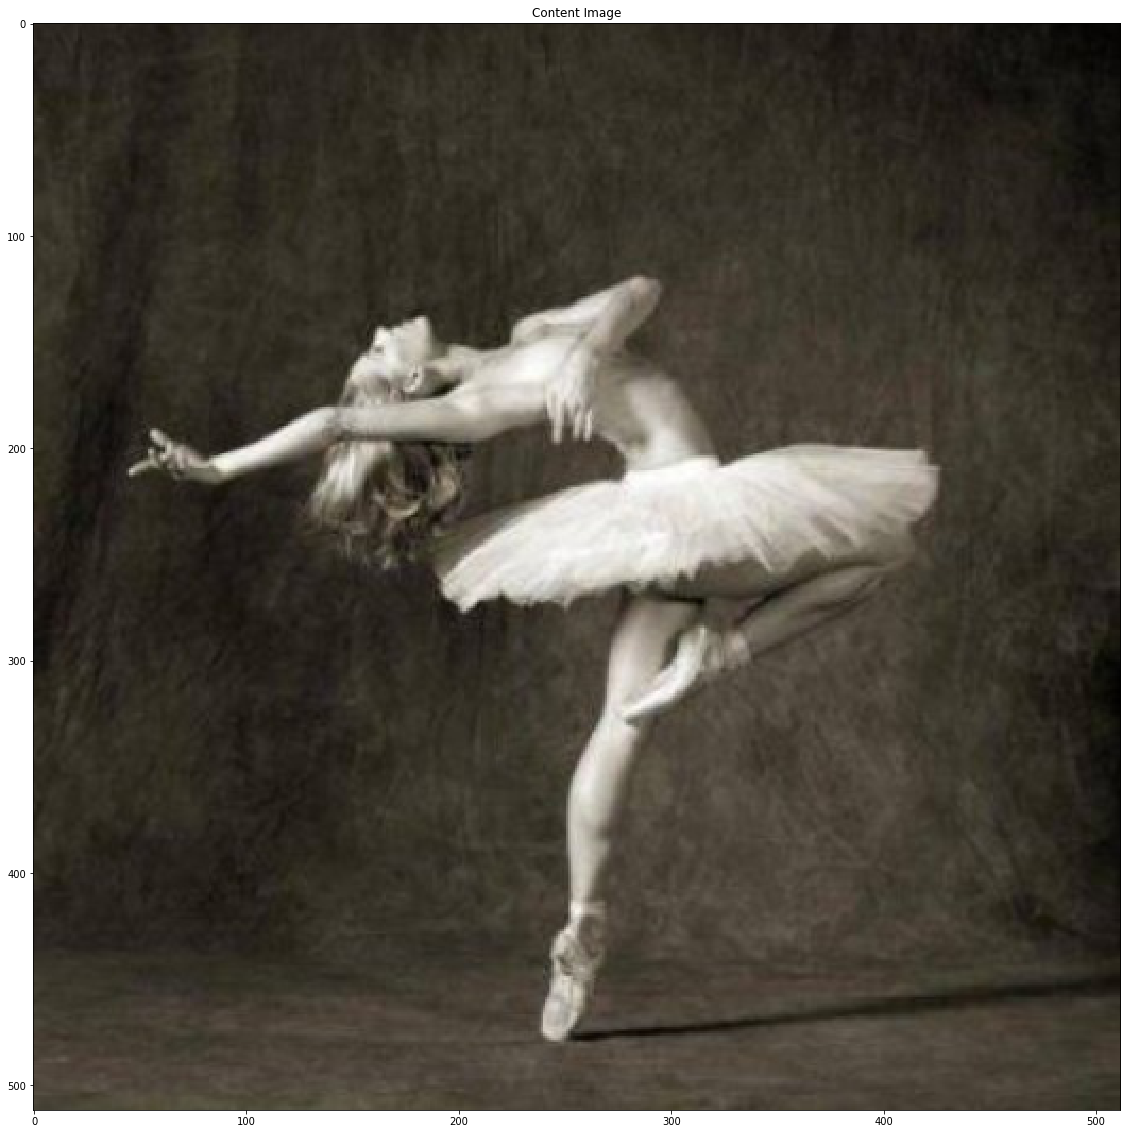

In [0]:
unloader = transforms.ToPILImage()  # reconvert into PIL image

plt.ion()

def imshow(tensor, title=None):
    image = tensor.cpu().clone()  # we clone the tensor to not do changes on it
    image = image.squeeze(0)      # remove the fake batch dimension
    image = unloader(image)
    plt.imshow(image)
    if title is not None:
        plt.title(title)
    plt.pause(0.001) # pause a bit so that plots are updated


plt.figure()
imshow(style_img, title='Style Image')

plt.figure()
imshow(content_img, title='Content Image')

In [0]:
class ContentLoss(nn.Module):

    def __init__(self, target,):
        super(ContentLoss, self).__init__()
        # we 'detach' the target content from the tree used
        # to dynamically compute the gradient: this is a stated value,
        # not a variable. Otherwise the forward method of the criterion
        # will throw an error.
        self.target = target.detach()

    def forward(self, input):
        self.loss = F.mse_loss(input, self.target)
        return input

In [0]:
def gram_matrix(input):
    a, b, c, d = input.size()  # a=batch size(=1)
    # b=number of feature maps
    # (c,d)=dimensions of a f. map (N=c*d)

    features = input.view(a * b, c * d)  # resise F_XL into \hat F_XL

    G = torch.mm(features, features.t())  # compute the gram product

    # we 'normalize' the values of the gram matrix
    # by dividing by the number of element in each feature maps.
    return G.div(a * b * c * d)

In [0]:
class StyleLoss(nn.Module):

    def __init__(self, target_feature):
        super(StyleLoss, self).__init__()
        self.target = gram_matrix(target_feature).detach()

    def forward(self, input):
        G = gram_matrix(input)
        self.loss = F.mse_loss(G, self.target)
        return input

In [0]:
cnn = models.vgg19(pretrained=True).features.to(device).eval()

Downloading: "https://download.pytorch.org/models/vgg19-dcbb9e9d.pth" to /root/.cache/torch/checkpoints/vgg19-dcbb9e9d.pth
100%|██████████| 548M/548M [00:07<00:00, 78.4MB/s]


In [0]:
cnn_normalization_mean = torch.tensor([0.485, 0.456, 0.406]).to(device)
cnn_normalization_std = torch.tensor([0.229, 0.224, 0.225]).to(device)

# create a module to normalize input image so we can easily put it in a
# nn.Sequential
class Normalization(nn.Module):
    def __init__(self, mean, std):
        super(Normalization, self).__init__()
        # .view the mean and std to make them [C x 1 x 1] so that they can
        # directly work with image Tensor of shape [B x C x H x W].
        # B is batch size. C is number of channels. H is height and W is width.
        self.mean = torch.tensor(mean).view(-1, 1, 1)
        self.std = torch.tensor(std).view(-1, 1, 1)

    def forward(self, img):
        # normalize img
        return (img - self.mean) / self.std

In [0]:
# desired depth layers to compute style/content losses :
content_layers_default = ['conv_4']
style_layers_default = ['conv_1', 'conv_2', 'conv_3', 'conv_4', 'conv_5']

def get_style_model_and_losses(cnn, normalization_mean, normalization_std,
                               style_img, content_img,
                               content_layers=content_layers_default,
                               style_layers=style_layers_default):
    cnn = copy.deepcopy(cnn)

    # normalization module
    normalization = Normalization(normalization_mean, normalization_std).to(device)

    # just in order to have an iterable access to or list of content/syle
    # losses
    content_losses = []
    style_losses = []

    # assuming that cnn is a nn.Sequential, so we make a new nn.Sequential
    # to put in modules that are supposed to be activated sequentially
    model = nn.Sequential(normalization)

    i = 0  # increment every time we see a conv
    for layer in cnn.children():
        if isinstance(layer, nn.Conv2d):
            i += 1
            name = 'conv_{}'.format(i)
        elif isinstance(layer, nn.ReLU):
            name = 'relu_{}'.format(i)
            # The in-place version doesn't play very nicely with the ContentLoss
            # and StyleLoss we insert below. So we replace with out-of-place
            # ones here.
            layer = nn.ReLU(inplace=False)
        elif isinstance(layer, nn.MaxPool2d):
            name = 'pool_{}'.format(i)
        elif isinstance(layer, nn.BatchNorm2d):
            name = 'bn_{}'.format(i)
        else:
            raise RuntimeError('Unrecognized layer: {}'.format(layer.__class__.__name__))

        model.add_module(name, layer)

        if name in content_layers:
            # add content loss:
            target = model(content_img).detach()
            content_loss = ContentLoss(target)
            model.add_module("content_loss_{}".format(i), content_loss)
            content_losses.append(content_loss)

        if name in style_layers:
            # add style loss:
            target_feature = model(style_img).detach()
            style_loss = StyleLoss(target_feature)
            model.add_module("style_loss_{}".format(i), style_loss)
            style_losses.append(style_loss)

    # now we trim off the layers after the last content and style losses
    for i in range(len(model) - 1, -1, -1):
        if isinstance(model[i], ContentLoss) or isinstance(model[i], StyleLoss):
            break

    model = model[:(i + 1)]

    return model, style_losses, content_losses

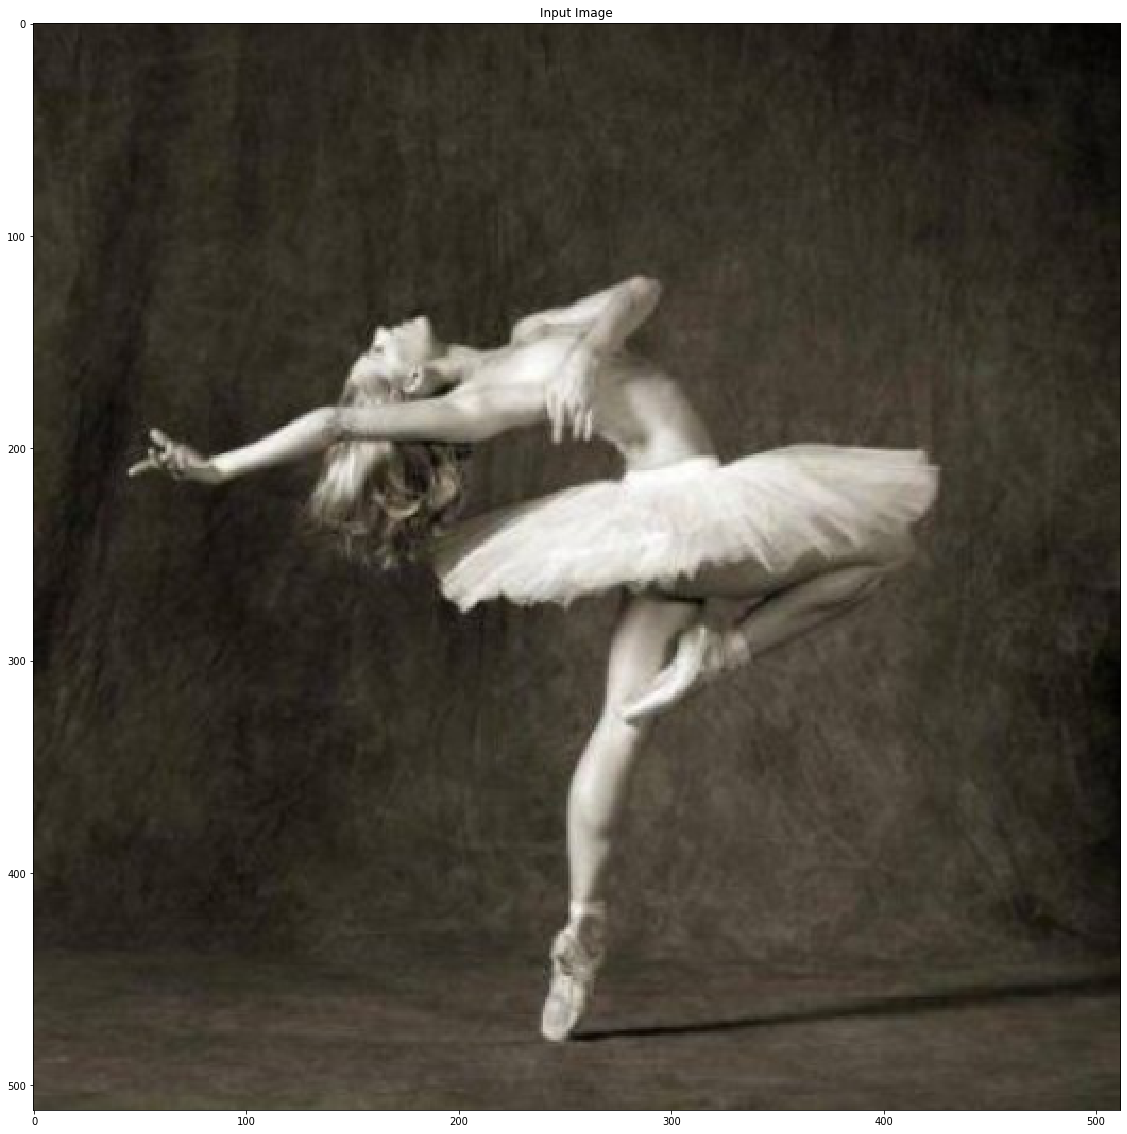

In [0]:
input_img = content_img.clone()
# if you want to use white noise instead uncomment the below line:
# input_img = torch.randn(content_img.data.size(), device=device)

# add the original input image to the figure:
plt.figure()
imshow(input_img, title='Input Image')

In [0]:
def get_input_optimizer(input_img):
    # this line to show that input is a parameter that requires a gradient
    optimizer = optim.LBFGS([input_img.requires_grad_()])
    return optimizer

In [0]:
def run_style_transfer(cnn, normalization_mean, normalization_std,
                       content_img, style_img, input_img, num_steps=300,
                       style_weight=1000000, content_weight=1):
    """Run the style transfer."""
    print('Building the style transfer model..')
    model, style_losses, content_losses = get_style_model_and_losses(cnn,
        normalization_mean, normalization_std, style_img, content_img)
    optimizer = get_input_optimizer(input_img)

    print('Optimizing..')
    run = [0]
    while run[0] <= num_steps:

        def closure():
            # correct the values of updated input image
            input_img.data.clamp_(0, 1)

            optimizer.zero_grad()
            model(input_img)
            style_score = 0
            content_score = 0

            for sl in style_losses:
                style_score += sl.loss
            for cl in content_losses:
                content_score += cl.loss

            style_score *= style_weight
            content_score *= content_weight

            loss = style_score + content_score
            loss.backward()

            run[0] += 1
            if run[0] % 50 == 0:
                print("run {}:".format(run))
                print('Style Loss : {:4f} Content Loss: {:4f}'.format(
                    style_score.item(), content_score.item()))
                print()

            return style_score + content_score

        optimizer.step(closure)

    # a last correction...
    input_img.data.clamp_(0, 1)

    return input_img

Building the style transfer model..
Optimizing..


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  if sys.path[0] == '':
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:13: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  del sys.path[0]


run [50]:
Style Loss : 4.009423 Content Loss: 4.198660

run [100]:
Style Loss : 1.116462 Content Loss: 3.018104

run [150]:
Style Loss : 0.707209 Content Loss: 2.655955

run [200]:
Style Loss : 0.470946 Content Loss: 2.497803

run [250]:
Style Loss : 0.341240 Content Loss: 2.410922

run [300]:
Style Loss : 0.259624 Content Loss: 2.355243



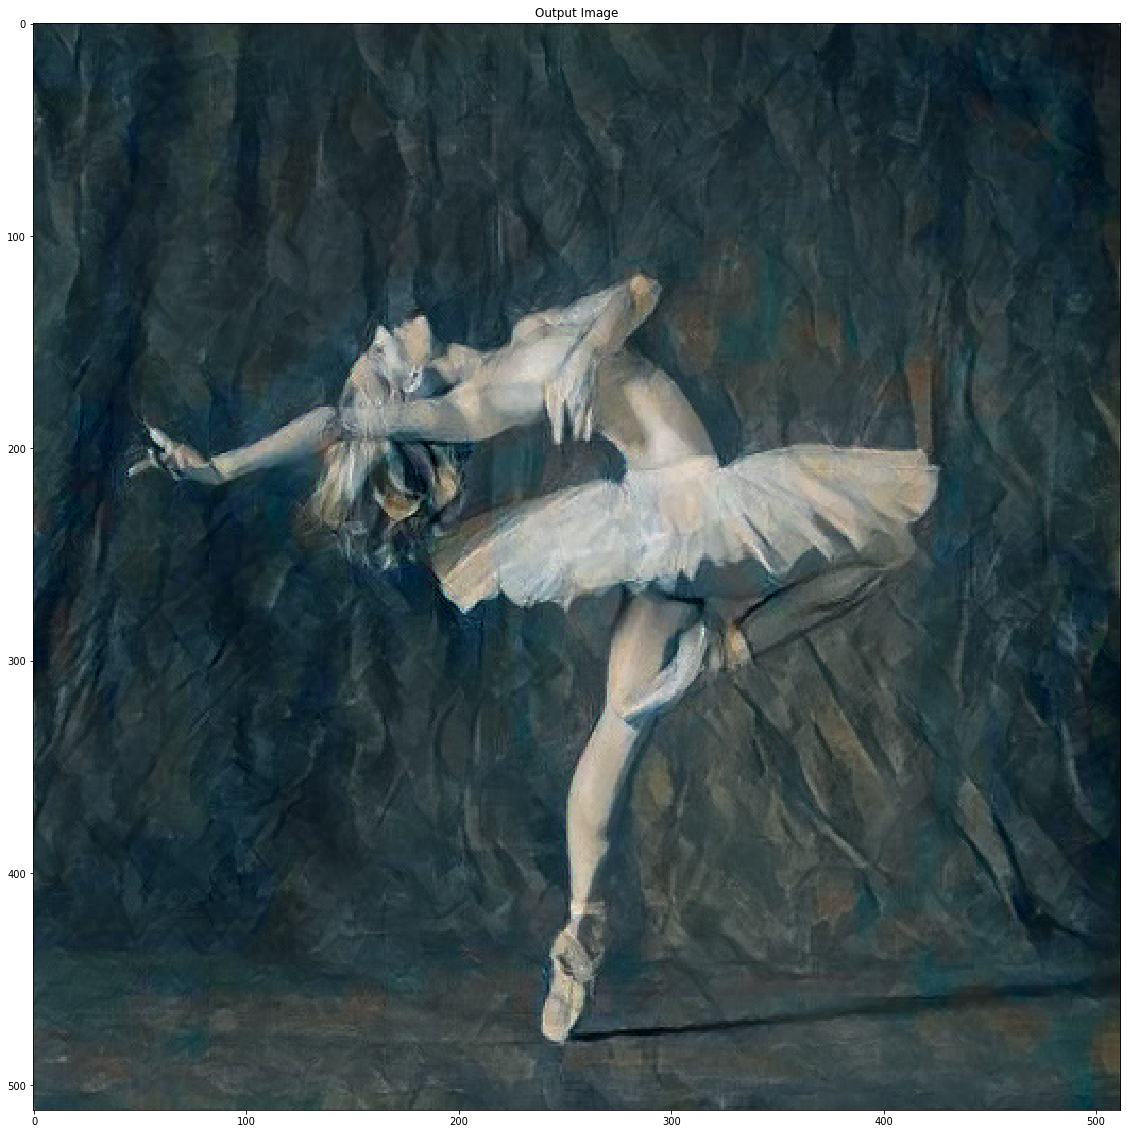

In [0]:
output = run_style_transfer(cnn, cnn_normalization_mean, cnn_normalization_std,
                            content_img, style_img, input_img)

plt.figure()
imshow(output, title='Output Image')

# sphinx_gallery_thumbnail_number = 4
plt.ioff()
plt.show()

In [0]:
По материалам:
1. https://github.com/sar-gupta/convisualize_nb/blob/master/cnn-visualize.ipynb
2. https://pytorch.org/tutorials/advanced/neural_style_tutorial.html

In [0]:
## Домашнее задание
1. Возьмите MNIST, обучите на нем сетку (LeNet)
2. Возьмите какую-нить картинку (из mnist'а)
3. Обучите шум, который при добавлении к оригинальной картинке, заставит ее ошибаться в пользу другого класса

SyntaxError: ignored